In [1]:
# The purpose of this notebook is to make noise patches from different sized FOVS and measure their changing NPS

In [2]:
from pathlib import Path
import numpy as np
import seaborn as sns

sns.set_theme()
sns.set_style('white')

from utils import compute_nps, radial_profile
datadir = Path('D:\Dev\Datasets\CCT189_CT_sims\CCT189_peds')

In [3]:
files = list(datadir.rglob('dose_100/*/signal_absent.mhd'))
files

[WindowsPath('D:/Dev/Datasets/CCT189_CT_sims/CCT189_peds/diameter112mm/fbp/dose_100/signal_absent/signal_absent.mhd'),
 WindowsPath('D:/Dev/Datasets/CCT189_CT_sims/CCT189_peds/diameter131mm/fbp/dose_100/signal_absent/signal_absent.mhd'),
 WindowsPath('D:/Dev/Datasets/CCT189_CT_sims/CCT189_peds/diameter151mm/fbp/dose_100/signal_absent/signal_absent.mhd'),
 WindowsPath('D:/Dev/Datasets/CCT189_CT_sims/CCT189_peds/diameter185mm/fbp/dose_100/signal_absent/signal_absent.mhd'),
 WindowsPath('D:/Dev/Datasets/CCT189_CT_sims/CCT189_peds/diameter200mm/fbp/dose_100/signal_absent/signal_absent.mhd'),
 WindowsPath('D:/Dev/Datasets/CCT189_CT_sims/CCT189_peds/diameter216mm/fbp/dose_100/signal_absent/signal_absent.mhd'),
 WindowsPath('D:/Dev/Datasets/CCT189_CT_sims/CCT189_peds/diameter292mm/fbp/dose_100/signal_absent/signal_absent.mhd'),
 WindowsPath('D:/Dev/Datasets/CCT189_CT_sims/CCT189_peds/diameter350mm/fbp/dose_100/signal_absent/signal_absent.mhd')]

In [4]:
dose=100
import SimpleITK as sitk
def load_mhd(mhd_file): return sitk.GetArrayFromImage(sitk.ReadImage(mhd_file))
sa_file_dict={d.stem : next(d.rglob(f'dose_{dose:03d}/*/signal_absent.mhd')) for d in datadir.glob('diameter*mm')}

In [5]:
sa = load_mhd(sa_file_dict['diameter292mm'])
sa.shape

sa_image_dict = {k: load_mhd(v)-1000 for k, v in sa_file_dict.items()}

Text(0.5, 1.0, '[112, 151, 292] mm')

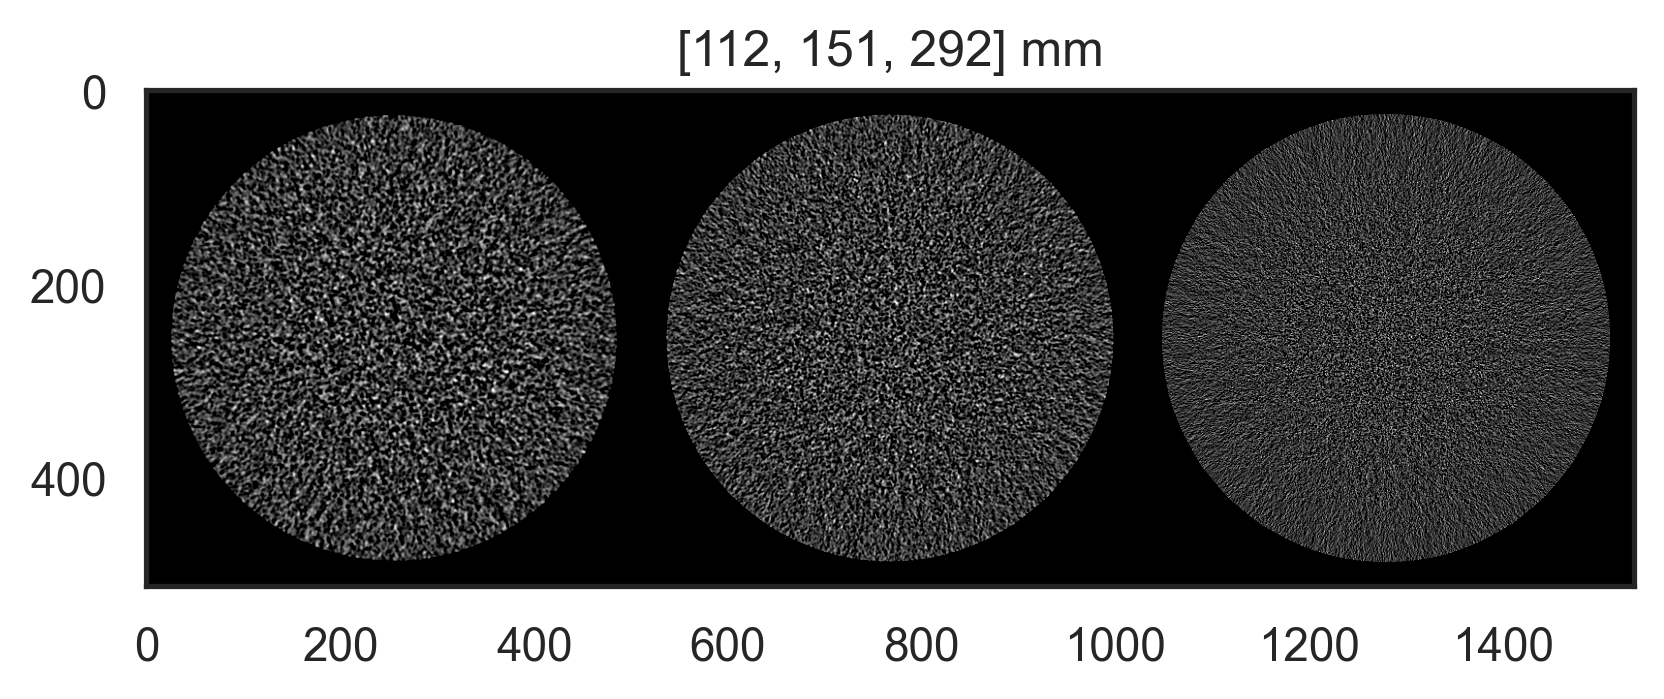

In [6]:
import matplotlib.pyplot as plt
diams = [112, 151, 292]
plt.subplots(1,1, dpi=300)
plt.imshow(np.concatenate([sa_image_dict[f'diameter{x}mm'][0] for x in diams], axis=1),cmap='gray', vmin=-20, vmax=80)
plt.title(f'{diams} mm')

In [7]:
import numpy as np
from itertools import combinations

def make_noise_images(sa_images, max_images = 2000):
    noise_images = []
    for idx, s in enumerate(combinations(sa_images, 2)):
        if idx < max_images:
            noise_images.append(s[1] - s[0])
    noise_images = np.array(noise_images)
    noise_images.reshape([*noise_images.shape, 1])
    return noise_images

make_noise_images(sa_image_dict['diameter112mm']).shape

(2000, 512, 512)

In [8]:
noise_image_dict = {k: make_noise_images(v, 2000) for k, v in sa_image_dict.items()}

Text(0.5, 1.0, '[112, 151, 292] mm whole noise images')

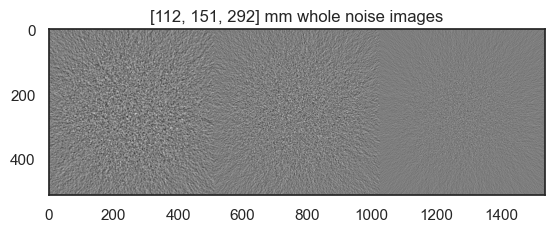

In [9]:
diams = [112, 151, 292]
plt.imshow(np.concatenate([noise_image_dict[f'diameter{x}mm'][0] for x in diams], axis=1), cmap='gray')
plt.title(f'{diams} mm whole noise images')

In [10]:
diams = [112, 151, 292]
nps_images = [compute_nps(noise_image_dict[f'diameter{x}mm']) for x in diams]

Text(0.5, 1.0, '[112, 151, 292] mm whole noise image nps')

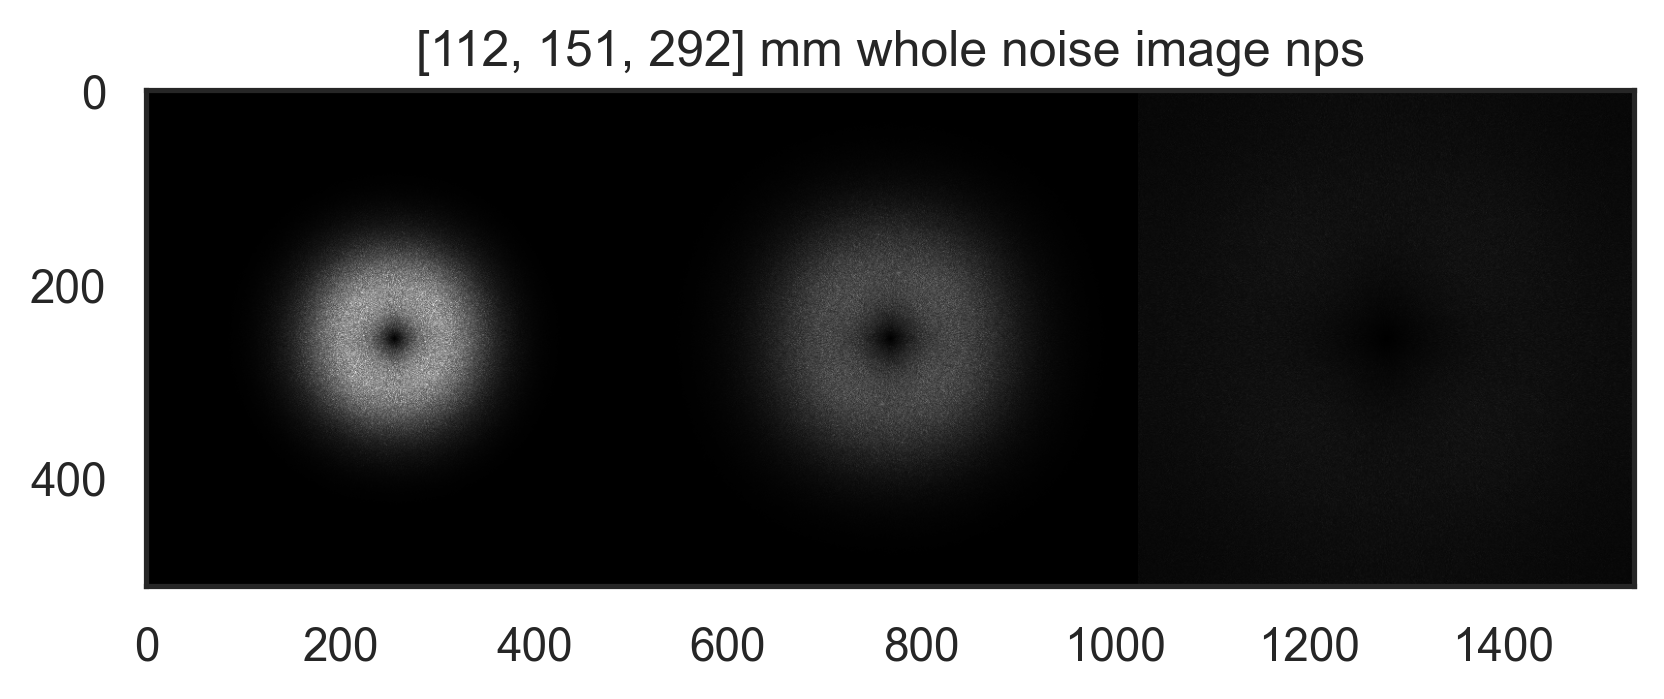

In [11]:
plt.subplots(1,1, dpi=300)
plt.imshow(np.concatenate(nps_images, axis=1), cmap='gray')
plt.title(f'{diams} mm whole noise image nps')

 noise texture changes radially and azimuthally

In [12]:
def get_corner_patches(img, patch_size=30):
    nz, nx, ny = img.shape
    return {'center': img[:, nx//2-patch_size//2:nx//2+patch_size//2, ny//2-patch_size//2:ny//2+patch_size//2],
            'top': img[:, :patch_size, ny//2-patch_size//2:ny//2+patch_size//2],
            'upper left': img[:, :patch_size, :patch_size]}
corner_patches = [get_corner_patches(noise_image_dict[f'diameter{x}mm']) for x in diams]

 look at image patches from different regions in the image

Text(0, 0.5, "Patch location ['upper left', 'top', 'center']")

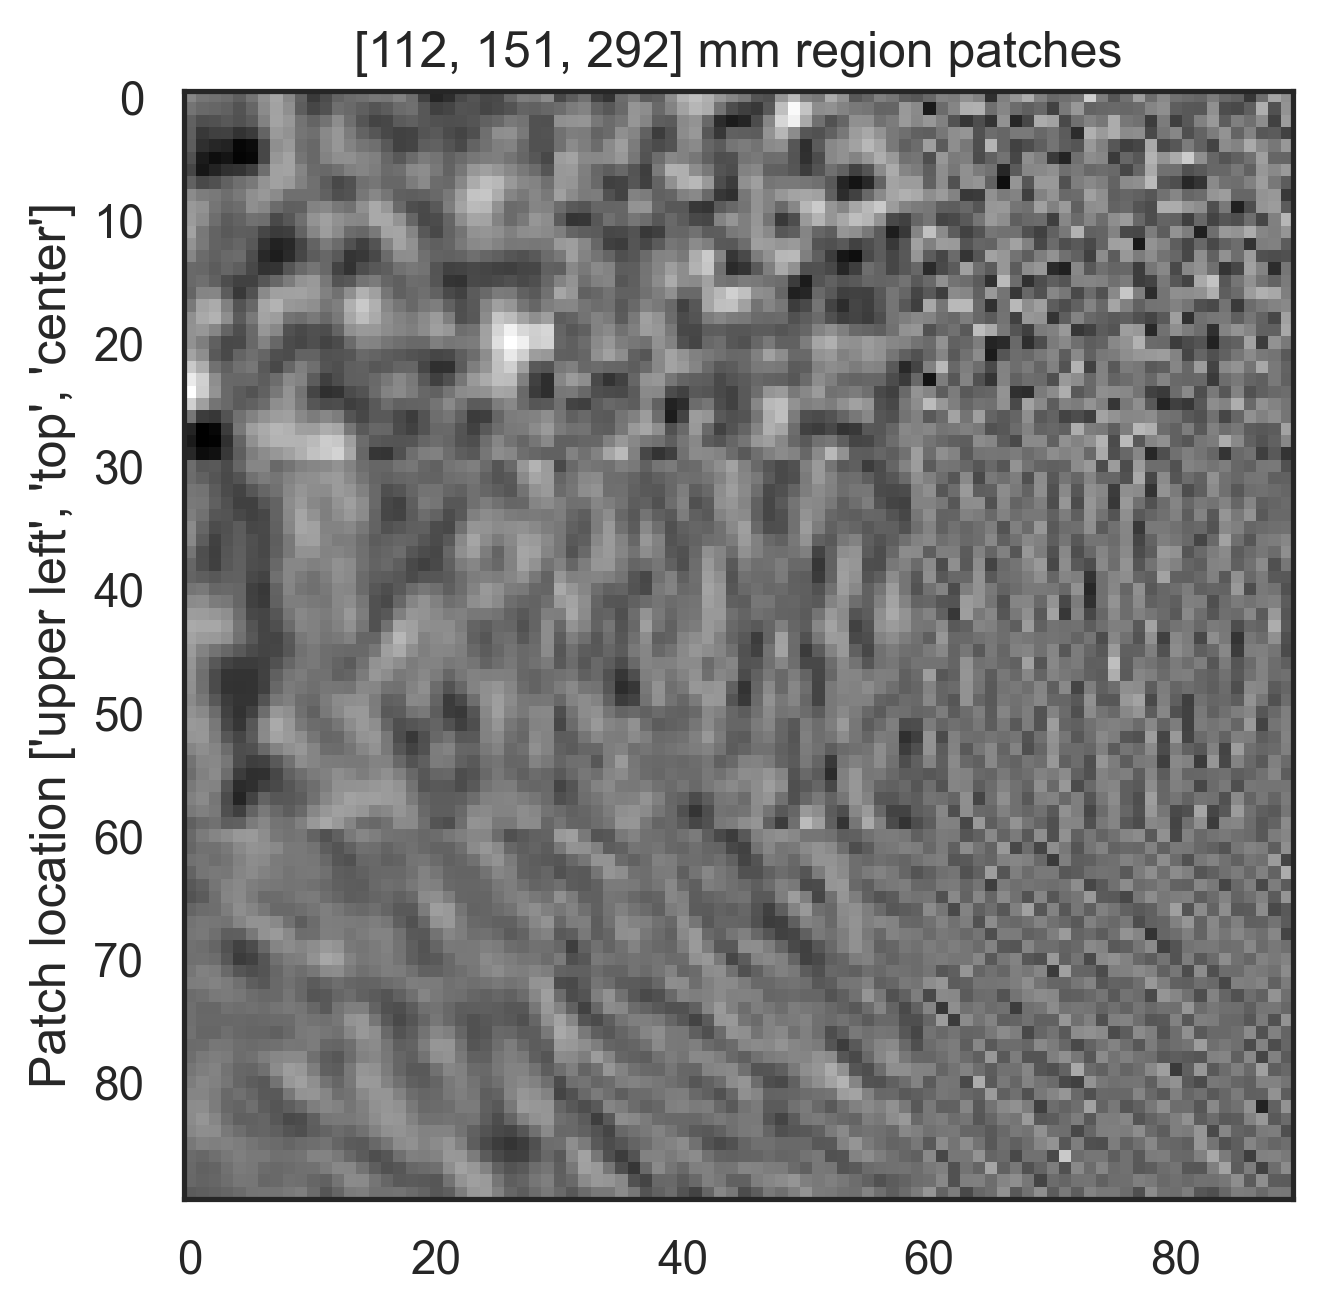

In [13]:
corners= list(corner_patches[0].keys())
plt.subplots(1,1, dpi=300)
region_patches = np.concatenate([np.concatenate([p[c][0] for p in corner_patches], axis=1) for c in corners])
plt.imshow(region_patches, cmap='gray')
plt.title(f'{diams} mm region patches')
plt.ylabel(f'Patch location {corners[::-1]}')

 let's look at the NPS in these regions

Text(0, 0.5, "Patch location ['upper left', 'top', 'center']")

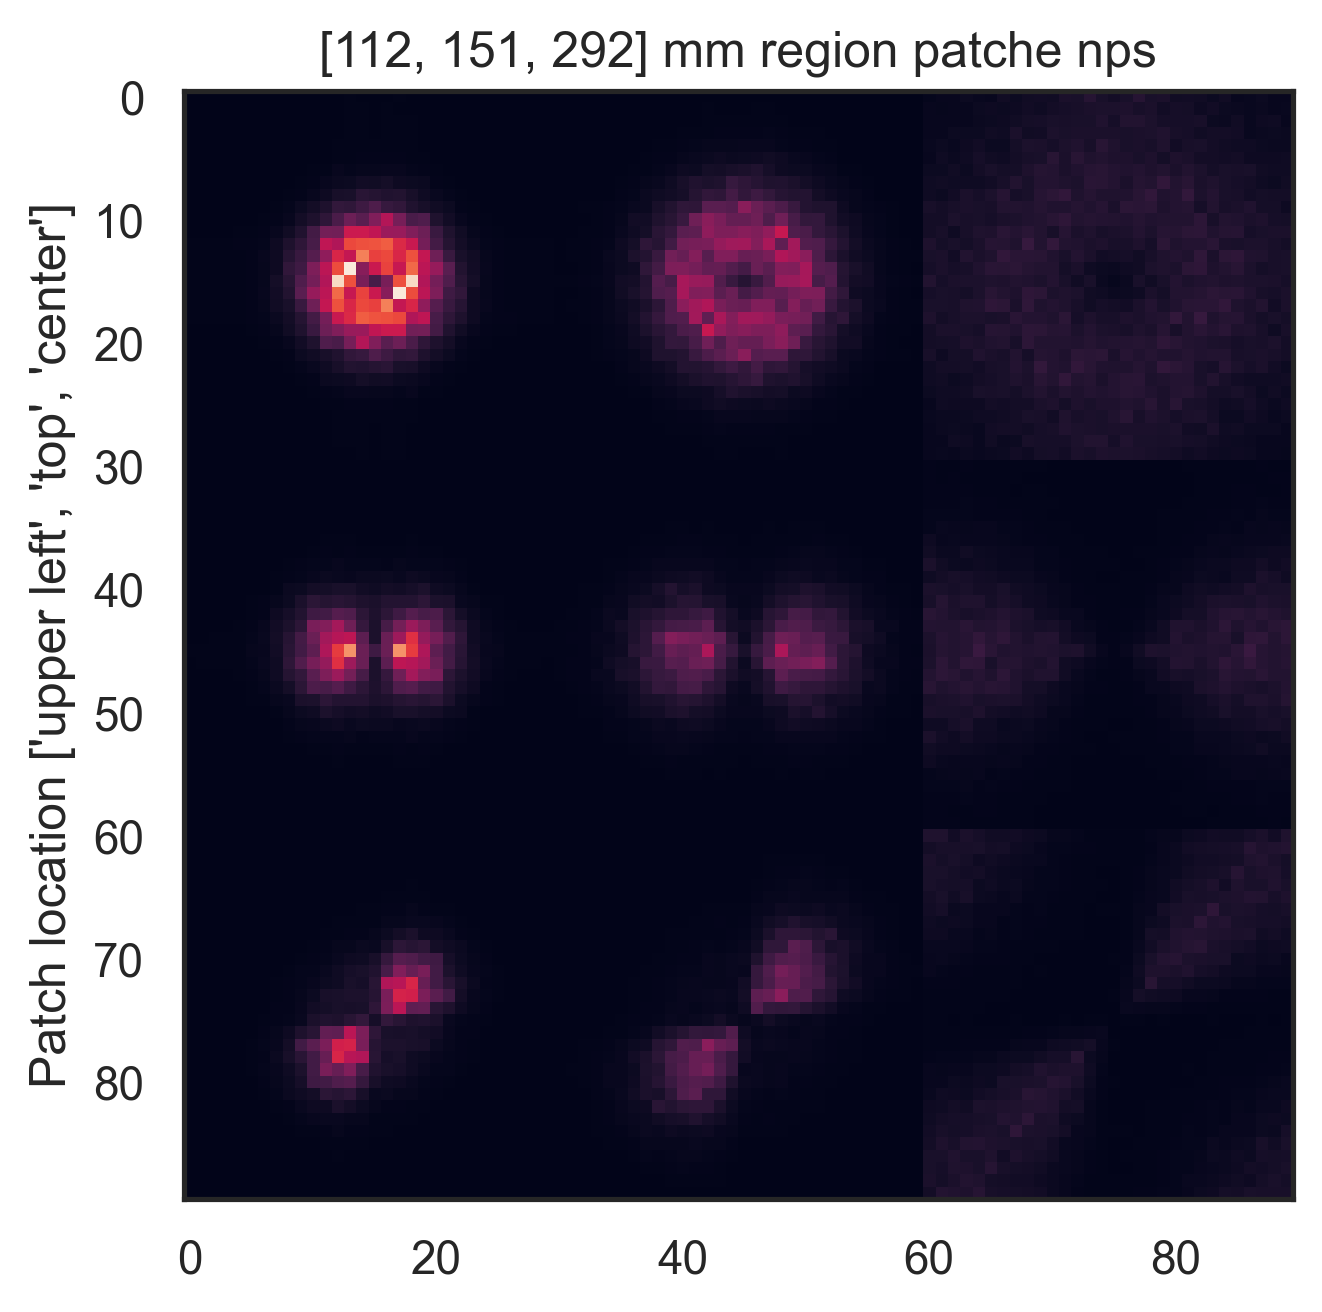

In [14]:
plt.subplots(1,1, dpi=300)
plt.imshow(np.concatenate([np.concatenate([compute_nps(p[c]) for p in corner_patches], axis=1) for c in corners]))
plt.title(f'{diams} mm region patche nps')
plt.ylabel(f'Patch location {corners[::-1]}')

Text(0.5, 1.0, 'Unnormalized NPS')

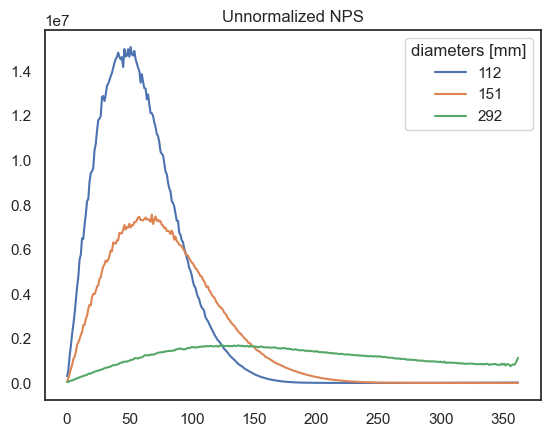

In [15]:
f, axs = plt.subplots()
for nps, diam in zip(nps_images, diams):
    axs.plot(radial_profile(nps), label=diam)
plt.legend(title='diameters [mm]')
plt.title('Unnormalized NPS')

In [16]:
from sklearn.feature_extraction.image import PatchExtractor

def make_noise_patches(noise_images, patch_sz=(30, 30), max_patches=30):
    return PatchExtractor(patch_size=patch_sz, max_patches=max_patches).transform(noise_images)

patch_sz = (30, 30)
make_noise_patches(noise_image_dict['diameter112mm'], patch_sz).shape

(60000, 30, 30)

In [17]:
noise_patch_dict = {k: make_noise_patches(v, patch_sz) for k, v in noise_image_dict.items()}

In [18]:
patch_nps = [compute_nps(noise_patch_dict[f'diameter{x}mm']) for x in diams]

Text(0.5, 1.0, '[112, 151, 292] mm averaged patch nps')

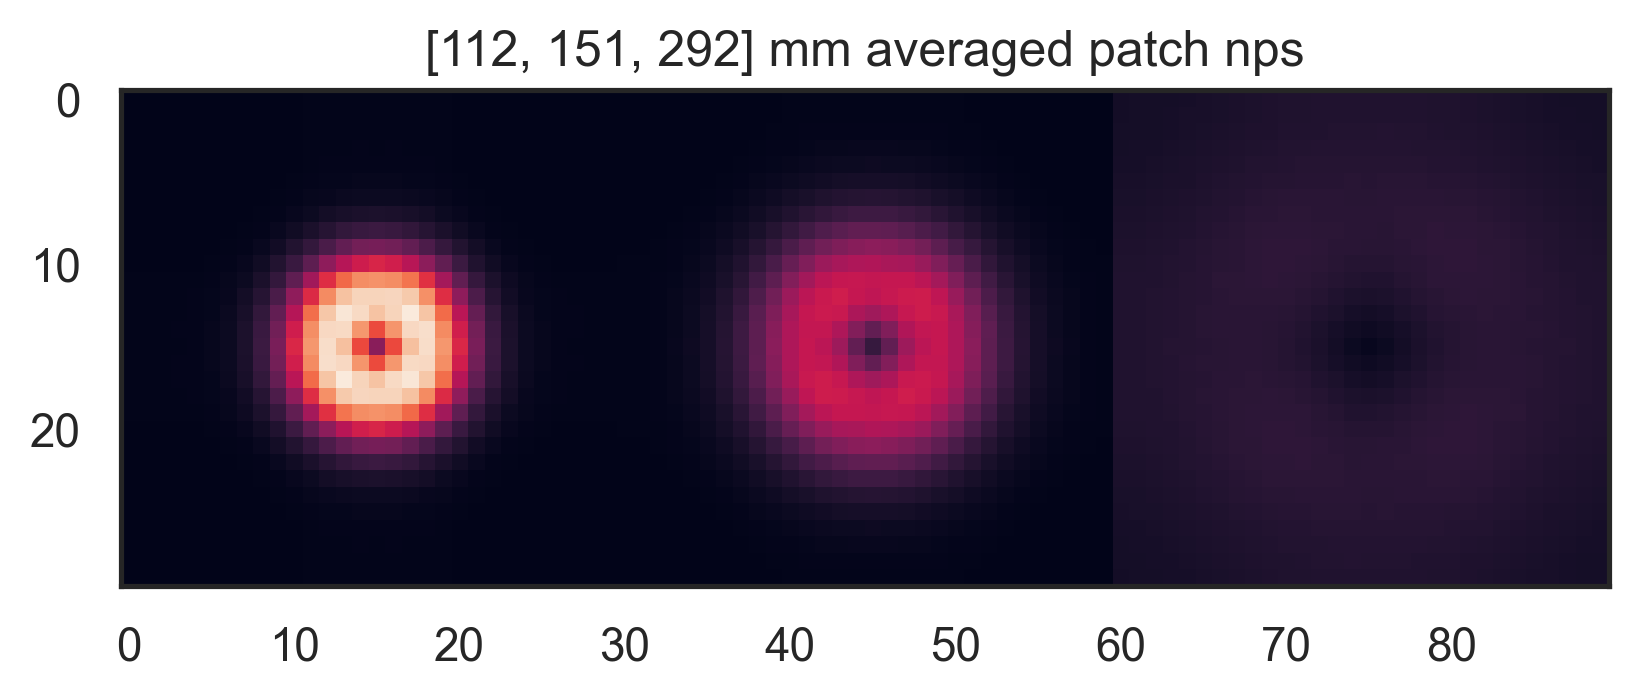

In [19]:
plt.subplots(1,1, dpi=300)
plt.imshow(np.concatenate(patch_nps, axis=1))
plt.title(f'{diams} mm averaged patch nps')

 how do these generated noise patches compare to the training dataset noise patches?

Text(0, 0.5, "Patch location ['upper left', 'top', 'center'] - Training Noise")

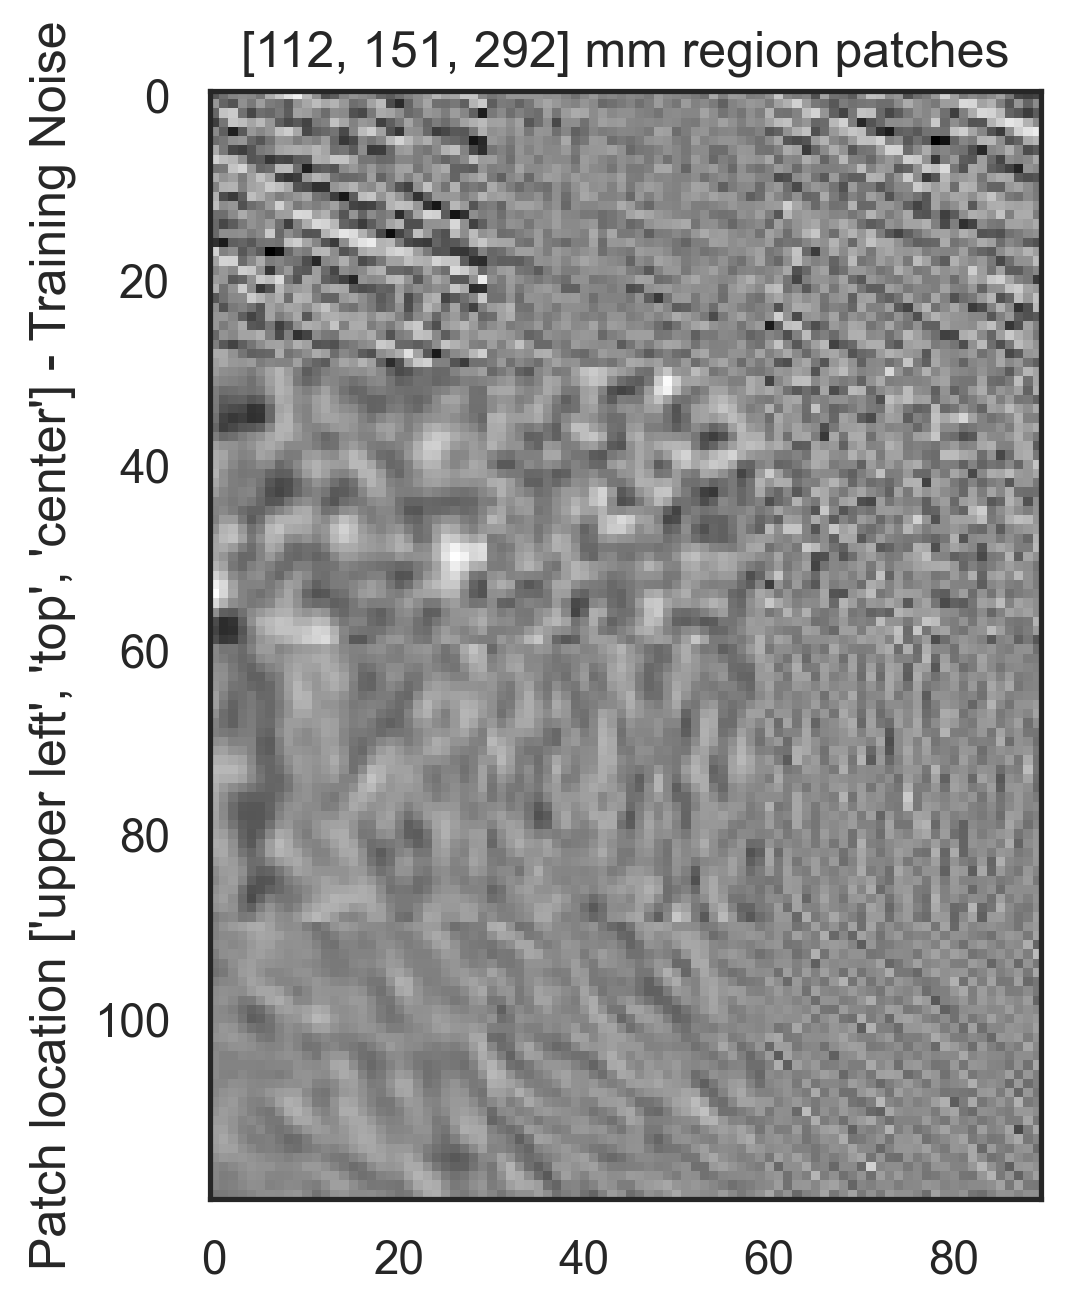

In [20]:
train_input = np.load('data/Denoising_Data/train_input.npy')
train_target = np.load('data/Denoising_Data/train_target.npy')
train_noise = train_target - train_input
f, axs = plt.subplots(dpi=300)
axs.imshow(np.concatenate([np.concatenate([np.squeeze(o) for o in train_noise[:3]], axis=1),
                           region_patches], axis=0), cmap='gray')
plt.title(f'{diams} mm region patches')
plt.ylabel(f'Patch location {corners[::-1]} - Training Noise')

 %% [markdown]

In [21]:
train_nps = compute_nps(train_noise)

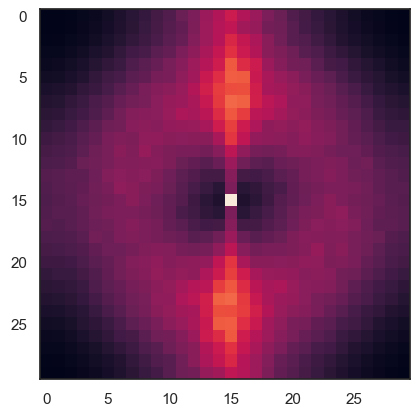

In [22]:
plt.imshow(train_nps)

Text(0.5, 1.0, '[112, 151, 292] mm averaged patch nps')

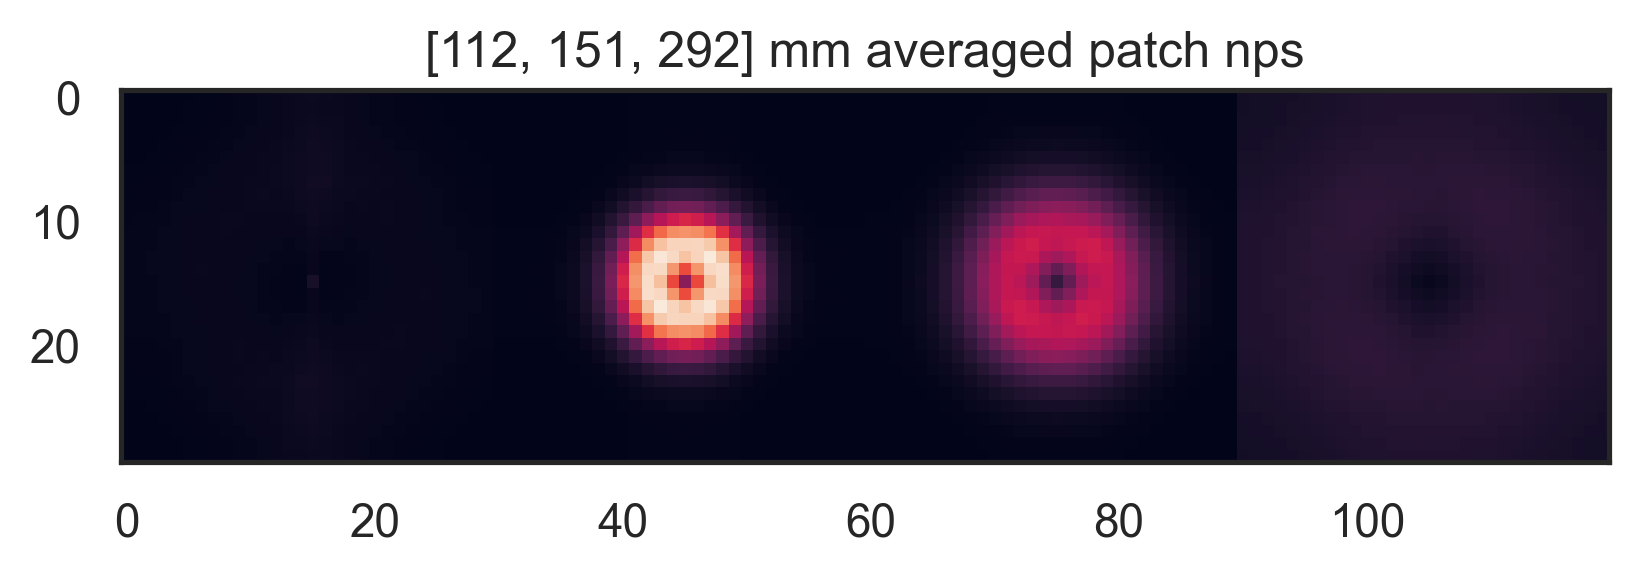

In [23]:
plt.subplots(1,1, dpi=300)
plt.imshow(np.concatenate([train_nps, *patch_nps], axis=1))
plt.title(f'{diams} mm averaged patch nps')

Text(0.5, 1.0, 'Generated Noise NPS vs. Training Patch NPS')

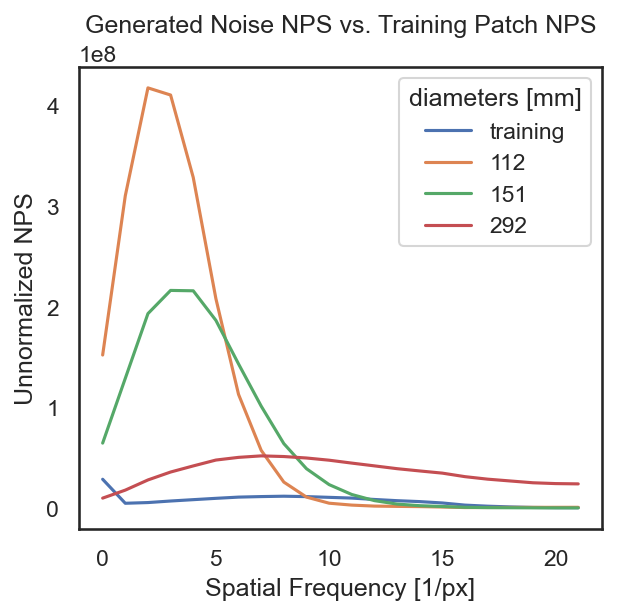

In [24]:
f, axs = plt.subplots(figsize=(4.5, 4), dpi=150)
for nps, diam in zip([train_nps, *patch_nps], ['training', *diams]):
    axs.plot(radial_profile(nps), label=diam)
plt.xlabel('Spatial Frequency [1/px]')
plt.ylabel('Unnormalized NPS')
plt.legend(title='diameters [mm]')
plt.title('Generated Noise NPS vs. Training Patch NPS')

 now save the noise patches

In [25]:
noise_patch_dir = Path('noise_patches')
noise_patch_dir.mkdir(exist_ok=True)

for k,v in noise_patch_dict.items():
    np.save(noise_patch_dir / f'{k}.npy', v)